In [11]:
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import  MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from time import time
import gc


In [2]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model


# Load and preprocess reduced dataset
print("Loading and preprocessing data : \n")

n_samples = 10000

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Reduce dataset size
x_train = x_train[:n_samples]
y_train = y_train[:n_samples]

# Using 1/4 of n_samples for test set
x_test = x_test[:n_samples//4]
y_test = y_test[:n_samples//4]

print(f"Training samples: {x_train.shape[0]}")
print(f"Testing samples: {x_test.shape[0]}")



Loading and preprocessing data : 

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training samples: 10000
Testing samples: 2500


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [4]:
def create_feature_extractors():

    ## Create feature extractors from different VGG19 layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    layers_to_extract = [
        'block3_conv2',
        'block4_conv3',
        'block5_conv4'
    ]


    feature_extractors = {
        layer: Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)
        for layer in layers_to_extract
    }

    return feature_extractors, layers_to_extract


In [7]:
#Extract the features in batches to manage the memory efficiently

def extract_features_in_batches(model, data, batch_size=32):

    num_samples = data.shape[0]
    features_list = []

    # Processing the  data in batches
    for i in range(0, num_samples, batch_size):
        batch_data = data[i:min(i + batch_size, num_samples)]

        # Extracting the features for the batch
        batch_features = model.predict(batch_data, verbose=0)

        # Reshaping features to 2D array
        batch_features_reshaped = batch_features.reshape(batch_features.shape[0], -1)
        features_list.append(batch_features_reshaped)

        # Clear memory
        del batch_data, batch_features
        gc.collect()

    # Combine all batches
    return np.concatenate(features_list, axis=0)

In [8]:
# Evaluation function

def evaluate_model(clf, X_train, X_test, y_train, y_test):

    # Training  the model
    start_time = time()
    clf.fit(X_train, y_train)
    train_time = time() - start_time

    # Make predictions
    start_time = time()
    y_pred = clf.predict(X_test)
    predict_time = time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    metrics = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'train_time': train_time,
        'predict_time': predict_time
    }

    print(f"{clf.__class__.__name__} Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    print("-" * 40)

    return metrics

In [9]:

# Create feature extractors
print("Creating feature extractors : \n")
feature_extractors, layer_names = create_feature_extractors()

# Extract features for each layer
print("Extracting features for each layer : ")
features_train = {}
features_test = {}

for layer in layer_names:
    print(f"\nProcessing layer: {layer}")

    # Extract features for training data
    print("Extracting training features : ")

    features_train[layer] = extract_features_in_batches(
        feature_extractors[layer],
        x_train,
        batch_size=32
    )

    # Extract features for test data
    print("Extracting test features...")
    features_test[layer] = extract_features_in_batches(
        feature_extractors[layer],
        x_test,
        batch_size=32
    )

    # Print feature shapes
    print(f"Features from {layer}:")
    print(f"Train shape: {features_train[layer].shape}")
    print(f"Test shape: {features_test[layer].shape}")



Creating feature extractors : 

Extracting features for each layer : 

Processing layer: block3_conv2
Extracting training features : 
Extracting test features...
Features from block3_conv2:
Train shape: (10000, 16384)
Test shape: (2500, 16384)

Processing layer: block4_conv3
Extracting training features : 
Extracting test features...
Features from block4_conv3:
Train shape: (10000, 8192)
Test shape: (2500, 8192)

Processing layer: block5_conv4
Extracting training features : 
Extracting test features...
Features from block5_conv4:
Train shape: (10000, 2048)
Test shape: (2500, 2048)


In [18]:
# Define different classifiers used for classification
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}



In [20]:
# Storing the results after each evaluation here
results = []

# For each layer and classifier combination
for layer in layer_names:
    print(f"\nLAYER USED : {layer}")

    # Scale features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(features_train[layer])
    x_test_scaled = scaler.transform(features_test[layer])

    # Evaluate each classifier one by one
    for clf_name, clf in classifiers.items():
        print(f"Evaluating {clf_name} :")

        metrics = evaluate_model(
            clf,
            x_train_scaled,
            x_test_scaled,
            y_train.argmax(axis=1),
            y_test.argmax(axis=1)
        )

        print()

        results.append({
            'Layer': layer,
            'Classifier': clf_name,
            **metrics
        })




LAYER USED : block3_conv2
Evaluating Logistic Regression :
LogisticRegression Metrics:
accuracy: 0.7112
precision: 0.7080
recall: 0.7112
f1: 0.7091
train_time: 53.4955
predict_time: 0.1994
----------------------------------------

Evaluating KNN :
KNeighborsClassifier Metrics:
accuracy: 0.5236
precision: 0.6108
recall: 0.5236
f1: 0.5214
train_time: 0.0938
predict_time: 26.8649
----------------------------------------

Evaluating Random Forest :
RandomForestClassifier Metrics:
accuracy: 0.5968
precision: 0.5919
recall: 0.5968
f1: 0.5925
train_time: 119.4140
predict_time: 0.1401
----------------------------------------

Evaluating Decision Tree :
DecisionTreeClassifier Metrics:
accuracy: 0.3304
precision: 0.3316
recall: 0.3304
f1: 0.3305
train_time: 222.0527
predict_time: 0.0172
----------------------------------------


LAYER USED : block4_conv3
Evaluating Logistic Regression :
LogisticRegression Metrics:
accuracy: 0.7088
precision: 0.7076
recall: 0.7088
f1: 0.7077
train_time: 35.4347


In [21]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best combination
best_idx = results_df['accuracy'].idxmax()
best_combination = results_df.iloc[best_idx]

# Print results
print("\nResults Summary:")
print(results_df.round(4))



Results Summary:
           Layer           Classifier  accuracy  precision  recall      f1  \
0   block3_conv2  Logistic Regression    0.7112     0.7080  0.7112  0.7091   
1   block3_conv2                  KNN    0.5236     0.6108  0.5236  0.5214   
2   block3_conv2        Random Forest    0.5968     0.5919  0.5968  0.5925   
3   block3_conv2        Decision Tree    0.3304     0.3316  0.3304  0.3305   
4   block4_conv3  Logistic Regression    0.7088     0.7076  0.7088  0.7077   
5   block4_conv3                  KNN    0.5488     0.5743  0.5488  0.5435   
6   block4_conv3        Random Forest    0.6112     0.6082  0.6112  0.6079   
7   block4_conv3        Decision Tree    0.3524     0.3520  0.3524  0.3514   
8   block5_conv4  Logistic Regression    0.4772     0.4759  0.4772  0.4763   
9   block5_conv4                  KNN    0.4156     0.4264  0.4156  0.4162   
10  block5_conv4        Random Forest    0.4920     0.4910  0.4920  0.4895   
11  block5_conv4        Decision Tree    0.298

In [23]:
print("\nBest Combination : \n")
print(f"Layer: {best_combination['Layer']}")
print(f"  Classifier: {best_combination['Classifier']}")
print(f"  Accuracy: {best_combination['accuracy']:.4f}")
print(f"  F1 Score: {best_combination['f1']:.4f}")
print(f"  Precision: {best_combination['precision']:.4f}")
print(f"  Recall: {best_combination['recall']:.4f}")


Best Combination : 

Layer: block3_conv2
  Classifier: Logistic Regression
  Accuracy: 0.7112
  F1 Score: 0.7091
  Precision: 0.7080
  Recall: 0.7112


In [24]:
results_df

,Layer,Classifier,accuracy,precision,recall,f1,train_time,predict_time
0,block3_conv2,Logistic Regression,0.7112,0.707951,0.7112,0.709083,53.495470,0.199412
1,block3_conv2,KNN,0.5236,0.610789,0.5236,0.521419,0.093800,26.864911
2,block3_conv2,Random Forest,0.5968,0.591878,0.5968,0.592525,119.414001,0.140121
3,block3_conv2,Decision Tree,0.3304,0.331609,0.3304,0.330535,222.052744,0.017242
4,block4_conv3,Logistic Regression,0.7088,0.707557,0.7088,0.707692,35.434690,0.129703
5,block4_conv3,KNN,0.5488,0.574333,0.5488,0.543543,0.047579,12.983659
6,block4_conv3,Random Forest,0.6112,0.608237,0.6112,0.607908,62.468225,0.173598
7,block4_conv3,Decision Tree,0.3524,0.351986,0.3524,0.351439,82.740882,0.008976
8,block5_conv4,Logistic Regression,0.4772,0.475899,0.4772,0.476336,62.242664,0.050000
9,block5_conv4,KNN,0.4156,0.426365,0.4156,0.416185,0.026869,4.469676


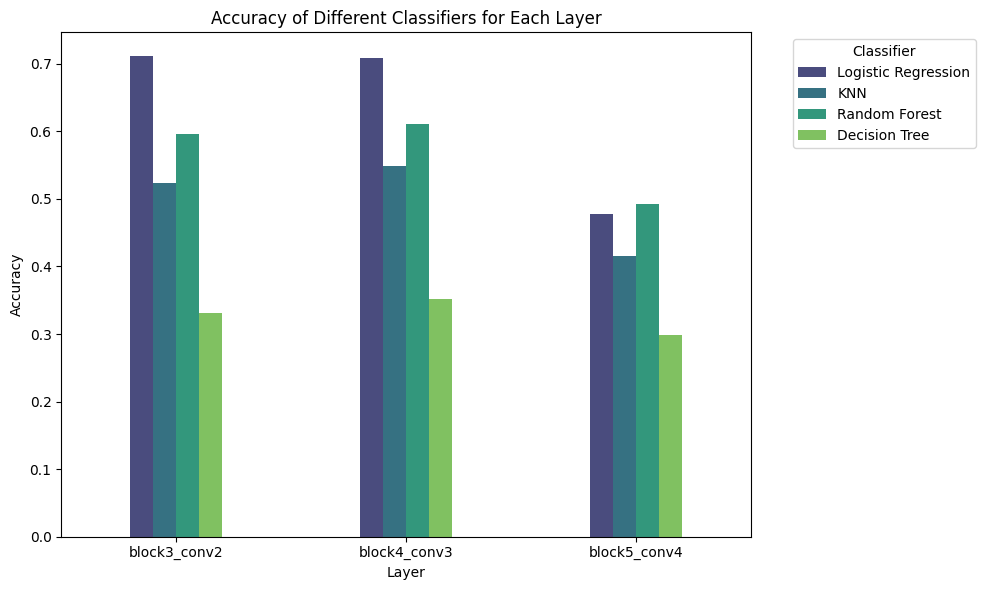

In [33]:


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'results_df' is your DataFrame from the previous code
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Layer', y='accuracy', hue='Classifier', data=results_df, palette="viridis", width=0.4)  # Using a different color palette and reduced width
plt.title('Accuracy of Different Classifiers for Each Layer')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left') #Move the legend outside the plot
plt.tight_layout()
plt.show()